In [1]:
# set working dir
import os
os.chdir("../")

In [2]:
from copy import deepcopy
from types import SimpleNamespace

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scienceplots
plt.style.reload_library()
plt.style.use("science")
import matplotlib.patheffects as path_effects
from matplotlib import ticker
from matplotlib.colors import colorConverter
import tol_colors as tc

from run import utils

Auto-Sklearn cannot be imported.


In [3]:
def getDf(config, mthd):
    df = pd.read_csv(getPath(config, mthd))
    return df

## Shortest Path 

In [4]:
# init config
config = SimpleNamespace()
config.prob = "sp"
config.grid = (5, 5)
config.feat = 5
config.deg = 4
config.noise = 0.5
config.net = []
config.optm = "adam"
config.l1 = 0.0
config.l2 = 0.0
config.rel = False
config.lan = "gurobi"
config.proc = 8
config.path = "./res"
config.sftp = False

In [5]:
def getPath(config, mthd):
    config = deepcopy(config)
    if mthd == "lr":
        config.mthd = "2s"
        config.pred = "lr"
    if mthd == "rf":
        config.mthd = "2s"
        config.pred = "rf"
    if mthd == "auto":
        config.mthd = "2s"
        config.pred = "auto"
        config.metric = "mse"
    if mthd == "spo":
        config.mthd = "spo"
        config.batch = 32
        config.lr = 1e-2
    if mthd == "spo l1":
        config.mthd = "spo"
        config.batch = 32
        config.lr = 1e-2
        config.l1 = 1e-2
    if mthd == "spo l2":
        config.mthd = "spo"
        config.batch = 32
        config.lr = 1e-2
        config.l2 = 1e-2
    if mthd == "dbb":
        config.mthd = "dbb"
        config.loss = "r"
        config.batch = 32
        config.lr = 1e-1
        config.smth = 20
    if mthd == "dbb l1":
        config.mthd = "dbb"
        config.loss = "r"
        config.batch = 32
        config.lr = 1e-1
        config.smth = 20
        config.l1 = 1e-2
    if mthd == "dbb l2":
        config.mthd = "dbb"
        config.loss = "r"
        config.batch = 32
        config.lr = 1e-1
        config.smth = 20
        config.l2 = 1e-2
    path = utils.getSavePath(config)
    return path

In [6]:
def lighten(color, amount=0.9):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = np.array(colorsys.rgb_to_hls(*mc.to_rgb(c)))
    return colorsys.hls_to_rgb(c[0],1-amount * (1-c[1]),c[2])

In [7]:
def drawPlot(config, data):
    # set config
    config = deepcopy(config)
    config.data = data
    # color map
    cset =  tc.tol_cset('light')
    cmap = tc.tol_cmap("rainbow_discrete")(np.linspace(0, 1, 22))
    colors = {"2-stage LR":lighten(cset.mint),
              "2-stage RF":lighten(cset.pink),
              "2-stage Auto":lighten("#777777"),
              "SPO+":lighten(cmap[16]),
              "SPO+ L1":lighten(cmap[16]),
              "SPO+ L2":lighten(cmap[16]),
              "DBB":lighten(cmap[7]),
              "DBB L1":lighten(cmap[7]),
              "DBB L2":lighten(cmap[7])}
    w = colorConverter.to_rgba("w", alpha=0.5) # white
    # makerstyle map
    # get df
    dfs = {}
    dfs["2-stage Auto"]  = getDf(config, "auto")
    dfs["2-stage RF"]    = getDf(config, "rf")
    dfs["2-stage LR"]    = getDf(config, "lr")
    dfs["SPO+"]          = getDf(config, "spo")
    dfs["SPO+ L1"]       = getDf(config, "spo l1")
    dfs["SPO+ L2"]       = getDf(config, "spo l2")
    #dfs["DBB"]           = getDf(config, "bb")
    #dfs["DBB L1"]        = getDf(config, "bb l1")
    #dfs["DBB L2"]        = getDf(config, "bb l2")
    # draw boxplot
    fig, ax = plt.subplots(figsize=(12,12))
    for mthd in dfs:
        df, c = dfs[mthd], colorConverter.to_rgba(colors[mthd], alpha=0.75)
        x, y = df["MSE"].mean(), df["Unamb SPO"].mean()
        size = int((np.log(df["Elapsed"].mean())+4)*1000)
        if mthd.split(" ")[-1] == "L1":
            ax.scatter(x, y, s=size, color=c, marker="o", hatch="++++", facecolor=w)
        elif mthd.split(" ")[-1] == "L2":
            ax.scatter(x, y, s=size, color=c, marker="o", hatch="OO..", facecolor=w)
        else:
            ax.scatter(x, y, s=size, color=c, marker="o")
        # adjust annotation
        if mthd == "2-stage LR":
            cord = (x, y-0.005)
        elif mthd == "2-stage RF":
            cord = (x, y+0.005)
        elif mthd == "2-stage Auto":
            cord = (x, y-0.01)
        elif mthd == "SPO+":
            cord = (x+0.012, y-0.012)
        elif mthd == "SPO+ L1":
            cord = (x+0.006, y-0.006)
        elif mthd == "SPO+ L2":
            cord = (x, y)
        else:
            cord = (x, y)
        # annotate
        txt = ax.annotate(mthd+" :{:.2f} Sec".format(df["Elapsed"].mean()), cord, fontsize=20, color=colors[mthd])
        txt.set_path_effects([path_effects.withStroke(linewidth=0.75, foreground="k")])
    # labels and ticks
    plt.xlabel("Mean Squared Error", fontsize=36)
    plt.xticks(fontsize=24)
    plt.ylabel("Normalized Regret", fontsize=36)
    plt.yticks(fontsize=24)
    plt.xlim(0.0, 2.0)
    plt.ylim(0.0, 0.2)
    plt.title("Shortest Path\nTraining Set Size = {}, Polynomial degree = {}, Noise Half−width = {}" \
              .format(config.data, config.deg, config.noise), fontsize=24)
    plt.show()
    fig.savefig("./images/td-sp-n{}e{}.pdf".format(data,int(10*config.noise)), dpi=300)

### n = 100

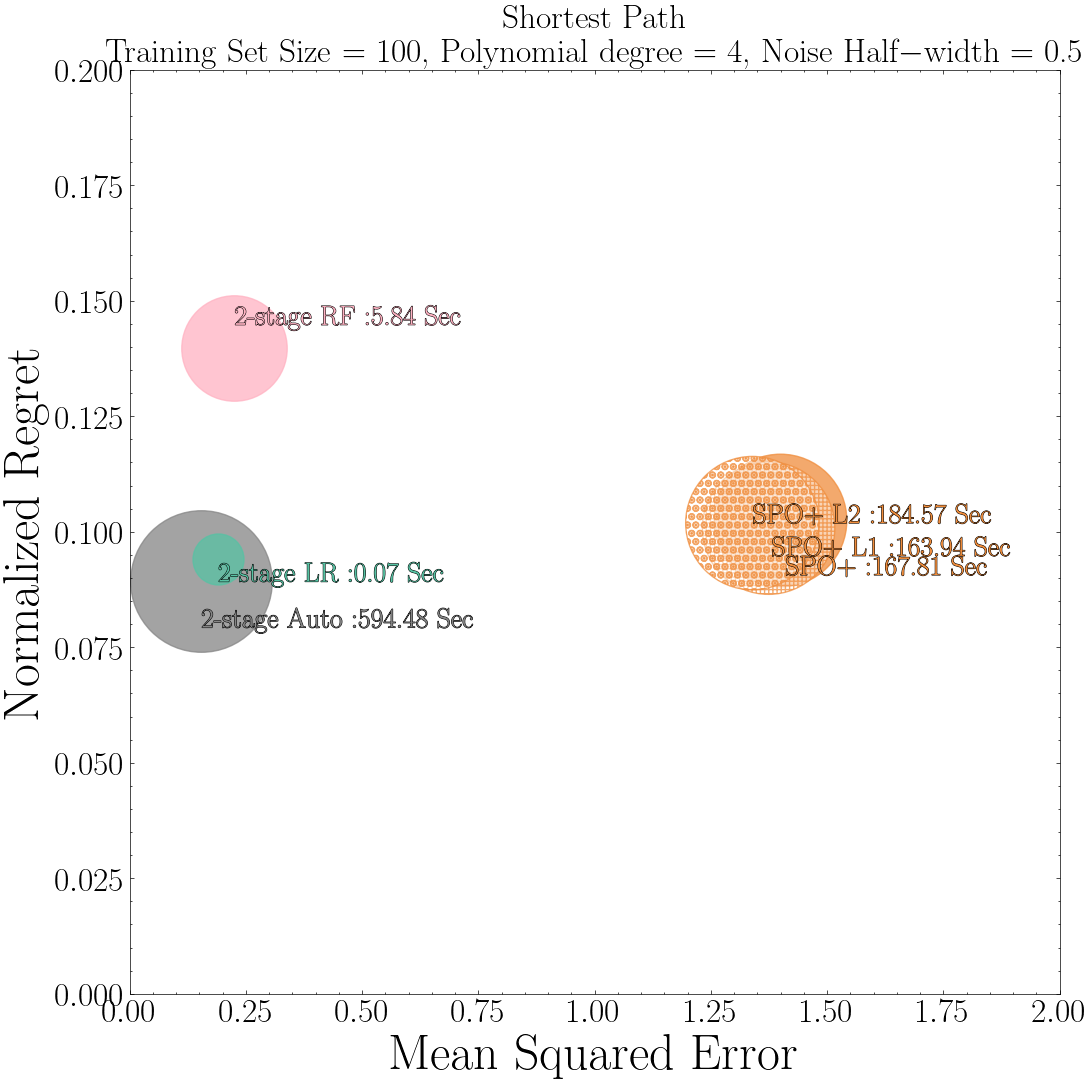

In [8]:
drawPlot(config, data=100)

### n = 1000

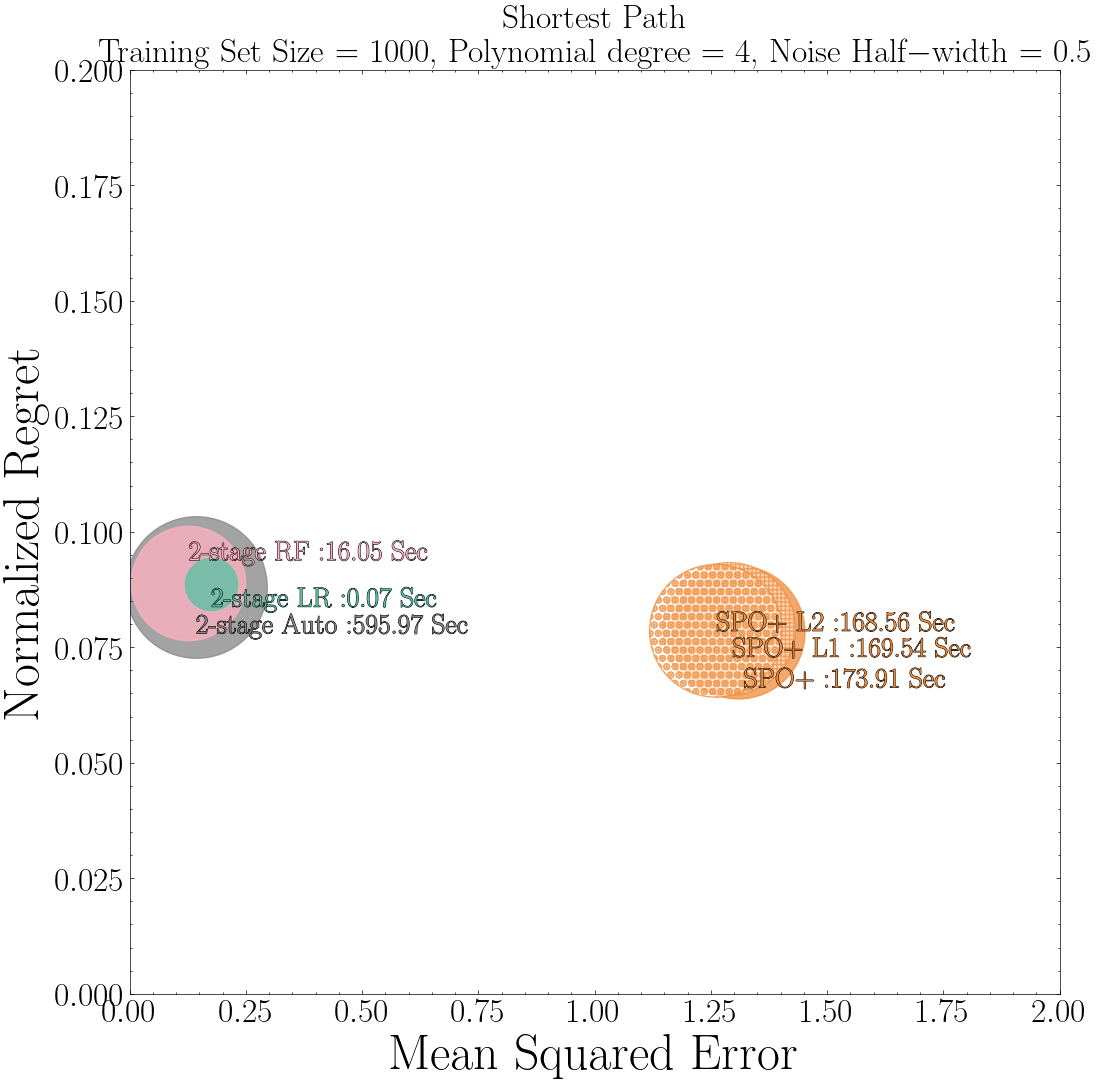

In [9]:
drawPlot(config, data=1000)

## Knapsack 

In [10]:
# init config
config = SimpleNamespace()
config.prob = "ks"
config.item = 32
config.dim = 2
config.cap = 20
config.feat = 5
config.deg = 4
config.noise = 0.5
config.net = []
config.optm = "adam"
config.batch = 32
config.l1 = 0.0
config.l2 = 0.0
config.rel = False
config.lan = "gurobi"
config.proc = 32
config.path = "./res"
config.sftp = False

In [11]:
def getPath(config, mthd):
    config = deepcopy(config)
    if mthd == "lr":
        config.mthd = "2s"
        config.pred = "lr"
    if mthd == "rf":
        config.mthd = "2s"
        config.pred = "rf"
    if mthd == "auto":
        config.mthd = "2s"
        config.pred = "auto"
        config.metric = "mse"
    if mthd == "spo":
        config.mthd = "spo"
        config.batch = 32
        config.lr = 1e-2
    if mthd == "spo rel":
        config.mthd = "spo"
        config.rel = True
        config.batch = 32
        config.lr = 1e-2
    if mthd == "spo l1":
        config.mthd = "spo"
        config.batch = 32
        config.lr = 1e-2
        config.l1 = 1e-2
    if mthd == "spo l2":
        config.mthd = "spo"
        config.batch = 32
        config.lr = 1e-2
        config.l2 = 1e-2
    if mthd == "dbb":
        config.mthd = "dbb"
        config.loss = "r"
        config.batch = 32
        config.lr = 1e-1
        config.smth = 10
    if mthd == "dbb rel":
        config.mthd = "dbb"
        config.loss = "r"
        config.rel = True
        config.batch = 32
        config.lr = 1e-1
        config.smth = 10
    if mthd == "dbb l1":
        config.mthd = "dbb"
        config.loss = "r"
        config.batch = 32
        config.lr = 1e-1
        config.smth = 10
        config.l1 = 1e-2
    if mthd == "dbb l2":
        config.mthd = "dbb"
        config.loss = "r"
        config.batch = 32
        config.lr = 1e-1
        config.smth = 10
        config.l2 = 1e-2
    path = utils.getSavePath(config)
    return path

In [12]:
def drawPlot(config, data):
    # set config
    config = deepcopy(config)
    config.data = data
    # color map
    cset =  tc.tol_cset('light')
    cmap = tc.tol_cmap("rainbow_discrete")(np.linspace(0, 1, 22))
    colors = {"2-stage LR":lighten(cset.mint),
              "2-stage RF":lighten(cset.pink),
              "2-stage Auto":lighten("#777777"),
              "SPO+":lighten(cmap[16]),
              "SPO+ L1":lighten(cmap[16]),
              "SPO+ L2":lighten(cmap[16]),
              "SPO+ Rel":lighten(cmap[14]),
              "DBB":lighten(cmap[7]),
              "DBB L1":lighten(cmap[7]),
              "DBB L2":lighten(cmap[7]),
              "DBB Rel":lighten(cmap[9])}
    w = colorConverter.to_rgba("w", alpha=0.5) # white
    # makerstyle map
    # get df
    dfs = {}
    dfs["SPO+"]          = getDf(config, "spo")
    dfs["SPO+ Rel"]      = getDf(config, "spo rel")
    dfs["SPO+ L1"]       = getDf(config, "spo l1")
    dfs["SPO+ L2"]       = getDf(config, "spo l2")
    #dfs["DBB"]           = getDf(config, "bb")
    #dfs["DBB Rel"]       = getDf(config, "bb rel")
    #dfs["DBB L1"]        = getDf(config, "bb l1")
    #dfs["DBB L2"]        = getDf(config, "bb l2")
    dfs["2-stage Auto"]  = getDf(config, "auto")
    dfs["2-stage RF"]    = getDf(config, "rf")
    dfs["2-stage LR"]    = getDf(config, "lr")
    # draw boxplot
    fig, ax = plt.subplots(figsize=(12,12))
    for mthd in dfs:
        df, c = dfs[mthd], colorConverter.to_rgba(colors[mthd], alpha=0.75)
        x, y = df["MSE"].mean(), df["Unamb SPO"].mean()
        size = int((np.log(df["Elapsed"].mean())+4)*1000)
        if mthd.split(" ")[-1] == "L1":
            ax.scatter(x, y, s=size, color=c, marker="o", hatch="++++", facecolor=w)
        elif mthd.split(" ")[-1] == "L2":
            ax.scatter(x, y, s=size, color=c, marker="o", hatch="OO..", facecolor=w)
        else:
            ax.scatter(x, y, s=size, color=c, marker="o")
        # adjust annotation
        if mthd == "2-stage Auto":
            cord = (x, y-0.01)
        elif mthd == "SPO+":
            cord = (x+0.012, y-0.012)
        elif mthd == "SPO+ L1":
            cord = (x+0.006, y-0.006)
        elif mthd == "SPO+ L2":
            cord = (x, y)
        elif mthd == "SPO+ Rel":
            if data == 100:
                cord = (x-0.4, y-0.018)
            if data == 1000:
                cord = (x+0.006, y+0.006)
        else:
            cord = (x, y)
        # annotate
        txt = ax.annotate(mthd+" :{:.2f} Sec".format(df["Elapsed"].mean()), cord, fontsize=20, color=colors[mthd])
        txt.set_path_effects([path_effects.withStroke(linewidth=0.75, foreground="k")])
    plt.xlabel("Mean Squared Error", fontsize=36)
    plt.xticks(fontsize=24)
    plt.ylabel("Normalized Regret", fontsize=36)
    plt.yticks(fontsize=24)
    plt.xlim(0.0, 24)
    plt.ylim(0.0, 0.21)
    plt.title("2D Knapsack\nTraining Set Size = {}, Polynomial degree = {}, Noise Half−width = {}" \
              .format(config.data, config.deg, config.noise), fontsize=24)
    plt.show()
    fig.savefig("./images/td-ks2-n{}e{}.pdf".format(data,int(10*config.noise)), dpi=300)

### n = 100 

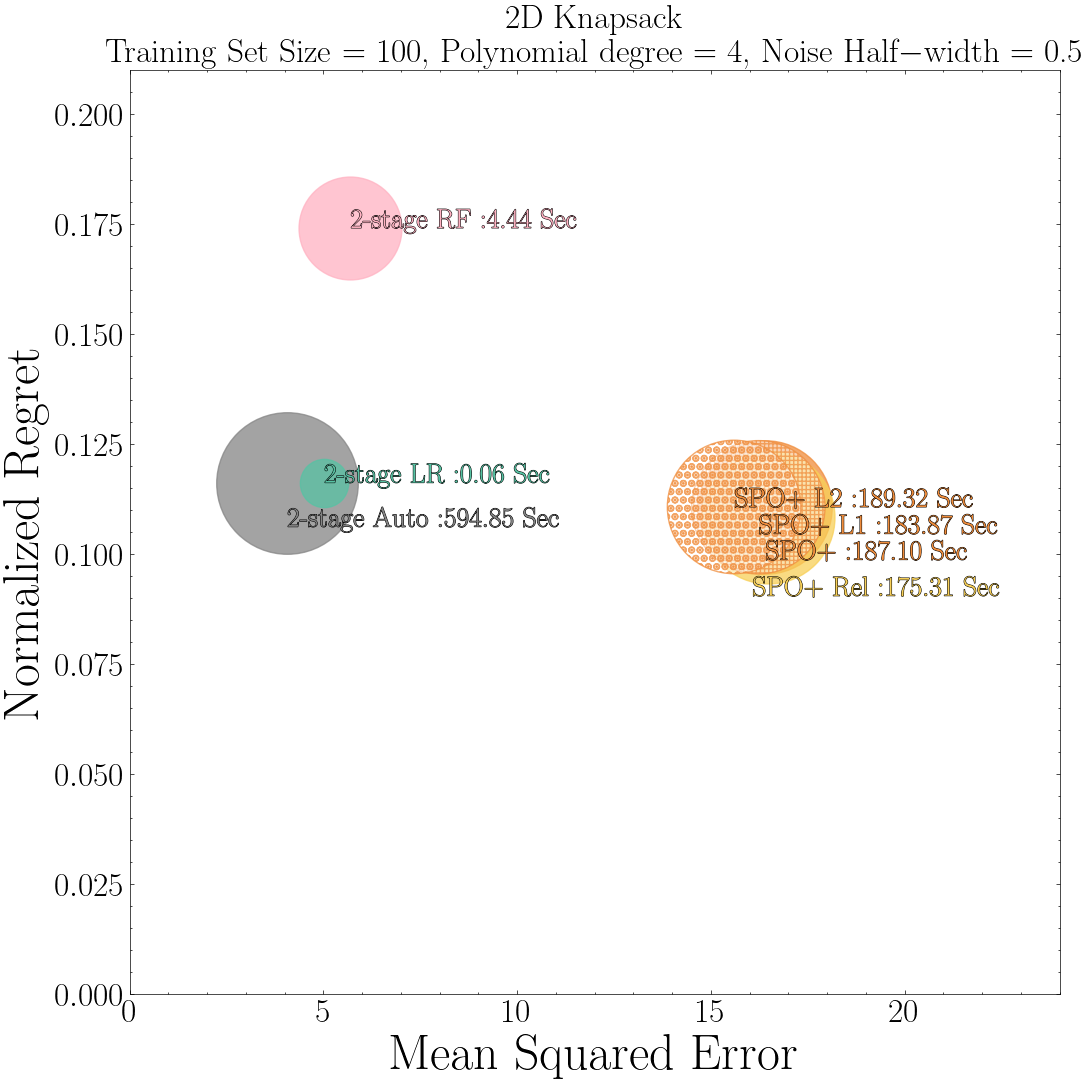

In [13]:
drawPlot(config, data=100)

### n = 1000 

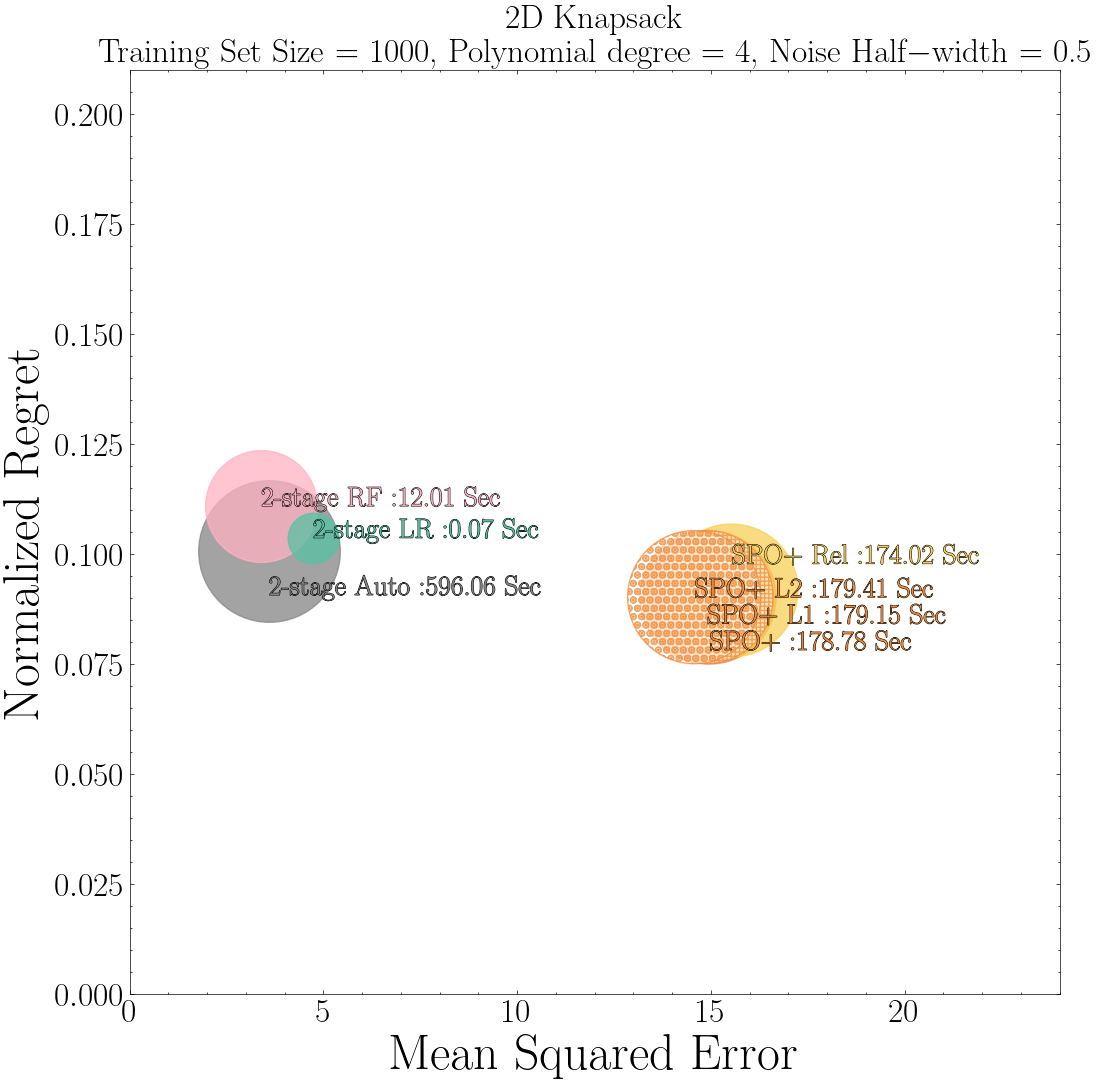

In [14]:
drawPlot(config, data=1000)

## TSP 

In [15]:
# init config
config = SimpleNamespace()
config.prob = "tsp"
config.nodes = 20
config.form = "dfj"
config.deg = 4
config.noise = 0.5
config.feat = 10
config.net = []
config.optm = "adam"
config.batch = 32
config.l1 = 0.0
config.l2 = 0.0
config.rel = False
config.lan = "gurobi"
config.proc = 32
config.path = "./res"
config.sftp = False

In [16]:
def getPath(config, mthd):
    config = deepcopy(config)
    if mthd == "lr":
        config.mthd = "2s"
        config.pred = "lr"
    if mthd == "rf":
        config.mthd = "2s"
        config.pred = "rf"
    if mthd == "auto":
        config.mthd = "2s"
        config.pred = "auto"
        config.metric = "mse"
    if mthd == "spo":
        config.mthd = "spo"
        config.batch = 32
        config.lr = 1e-2
    if mthd == "spo rel(gg)":
        config.mthd = "spo"
        config.batch = 32
        config.lr = 1e-2
        config.form = "gg"
        config.rel = True
    if mthd == "spo rel(mtz)":
        config.mthd = "spo"
        config.batch = 32
        config.lr = 1e-2
        config.form = "mtz"
        config.rel = True
    if mthd == "spo l1":
        config.mthd = "spo"
        config.batch = 32
        config.lr = 1e-2
        config.l1 = 1e-2
    if mthd == "spo l2":
        config.mthd = "spo"
        config.batch = 32
        config.lr = 1e-2
        config.l2 = 1e-2
    if mthd == "dbb":
        config.mthd = "dbb"
        config.loss = "r"
        config.batch = 32
        config.lr = 5e-2
        config.smth = 10
    if mthd == "dbb rel(gg)":
        config.mthd = "dbb"
        config.loss = "r"
        config.batch = 32
        config.lr = 5e-2
        config.form = "gg"
        config.smth = 20
        config.rel = True
    if mthd == "dbb rel(mtz)":
        config.mthd = "dbb"
        config.loss = "r"
        config.batch = 32
        config.lr = 5e-2
        config.form = "mtz"
        config.smth = 20
        config.rel = True
    if mthd == "dbb l1":
        config.mthd = "dbb"
        config.loss = "r"
        config.batch = 32
        config.lr = 5e-2
        config.smth = 10
        config.l1 = 1e-2
    if mthd == "dbb l2":
        config.mthd = "dbb"
        config.loss = "r"
        config.batch = 32
        config.lr = 5e-2
        config.smth = 10
        config.l2 = 1e-2
    path = utils.getSavePath(config)
    return path

In [17]:
def drawPlot(config, data):
    # set config
    config = deepcopy(config)
    config.data = data
    # color map
    cset =  tc.tol_cset('light')
    cmap = tc.tol_cmap("rainbow_discrete")(np.linspace(0, 1, 22))
    colors = {"2-stage LR":lighten(cset.mint),
              "2-stage RF":lighten(cset.pink),
              "2-stage Auto":lighten("#777777"),
              "SPO+":lighten(cmap[16]),
              "SPO+ L1":lighten(cmap[16]),
              "SPO+ L2":lighten(cmap[16]),
              "SPO+ Rel(GG)":lighten(cmap[15]),
              "SPO+ Rel(MTZ)":lighten(cmap[14]),
              "DBB":lighten(cmap[7]),
              "DBB L1":lighten(cmap[7]),
              "DBB L2":lighten(cmap[7]),
              "DBB Rel(GG)":lighten(cmap[8]),
              "DBB Rel(MTZ)":lighten(cmap[9])}
    w = colorConverter.to_rgba("w", alpha=0.5) # white
    # makerstyle map
    # get df
    dfs = {}
    dfs["SPO+"]          = getDf(config, "spo")
    dfs["SPO+ Rel(GG)"]  = getDf(config, "spo rel(gg)")
    dfs["SPO+ Rel(MTZ)"] = getDf(config, "spo rel(mtz)")
    dfs["SPO+ L1"]       = getDf(config, "spo l1")
    dfs["SPO+ L2"]       = getDf(config, "spo l2")
    #dfs["DBB"]           = getDf(config, "dbb")
    #dfs["DBB Rel(GG)"]   = getDf(config, "dbb rel(gg)")
    #dfs["DBB Rel(MTZ)"]  = getDf(config, "dbb rel(mtz)")
    #dfs["DBB L1"]        = getDf(config, "dbb l1")
    #dfs["DBB L2"]        = getDf(config, "dbb l2")
    dfs["2-stage Auto"]  = getDf(config, "auto")
    dfs["2-stage RF"]    = getDf(config, "rf")
    dfs["2-stage LR"]    = getDf(config, "lr")
    # draw boxplot
    fig, ax = plt.subplots(figsize=(12,12))
    for mthd in dfs:
        df, c = dfs[mthd], colorConverter.to_rgba(colors[mthd], alpha=0.75)
        x, y = df["MSE"].mean(), df["Unamb SPO"].mean()
        size = int((np.log(df["Elapsed"].mean())+4)*1000)
        if mthd.split(" ")[-1] == "L1":
            ax.scatter(x, y, s=size, color=c, marker="o", hatch="++++", facecolor=w)
        elif mthd.split(" ")[-1] == "L2":
            ax.scatter(x, y, s=size, color=c, marker="o", hatch="OO..", facecolor=w)
        else:
            ax.scatter(x, y, s=size, color=c, marker="o")
        # adjust annotation
        if mthd == "2-stage Auto":
            cord = (x, y-0.0045)
        elif mthd == "SPO+":
            cord = (x+0.012, y-0.012)
        elif mthd == "SPO+ L1":
            cord = (x+0.006, y-0.006)
        elif mthd == "SPO+ L2":
            cord = (x, y)
        else:
            cord = (x, y)
        # annotate
        txt = ax.annotate(mthd+" :{:.2f} Sec".format(df["Elapsed"].mean()), cord, fontsize=20, color=colors[mthd])
        txt.set_path_effects([path_effects.withStroke(linewidth=0.75, foreground="k")])
    plt.xlabel("Mean Squared Error", fontsize=36)
    plt.xticks(fontsize=24)
    plt.ylabel("Normalized Regret", fontsize=36)
    plt.yticks(fontsize=24)
    plt.xlim(0.0, 90)
    plt.ylim(0.0, 0.2)
    plt.title("TSP\nTraining Set Size = {}, Polynomial degree = {}, Noise Half−width = {}" \
              .format(config.data, config.deg, config.noise), fontsize=24)
    plt.show()
    fig.savefig("./images/td-tsp-n{}e{}.pdf".format(data,int(10*config.noise)), dpi=300)

### n = 100 

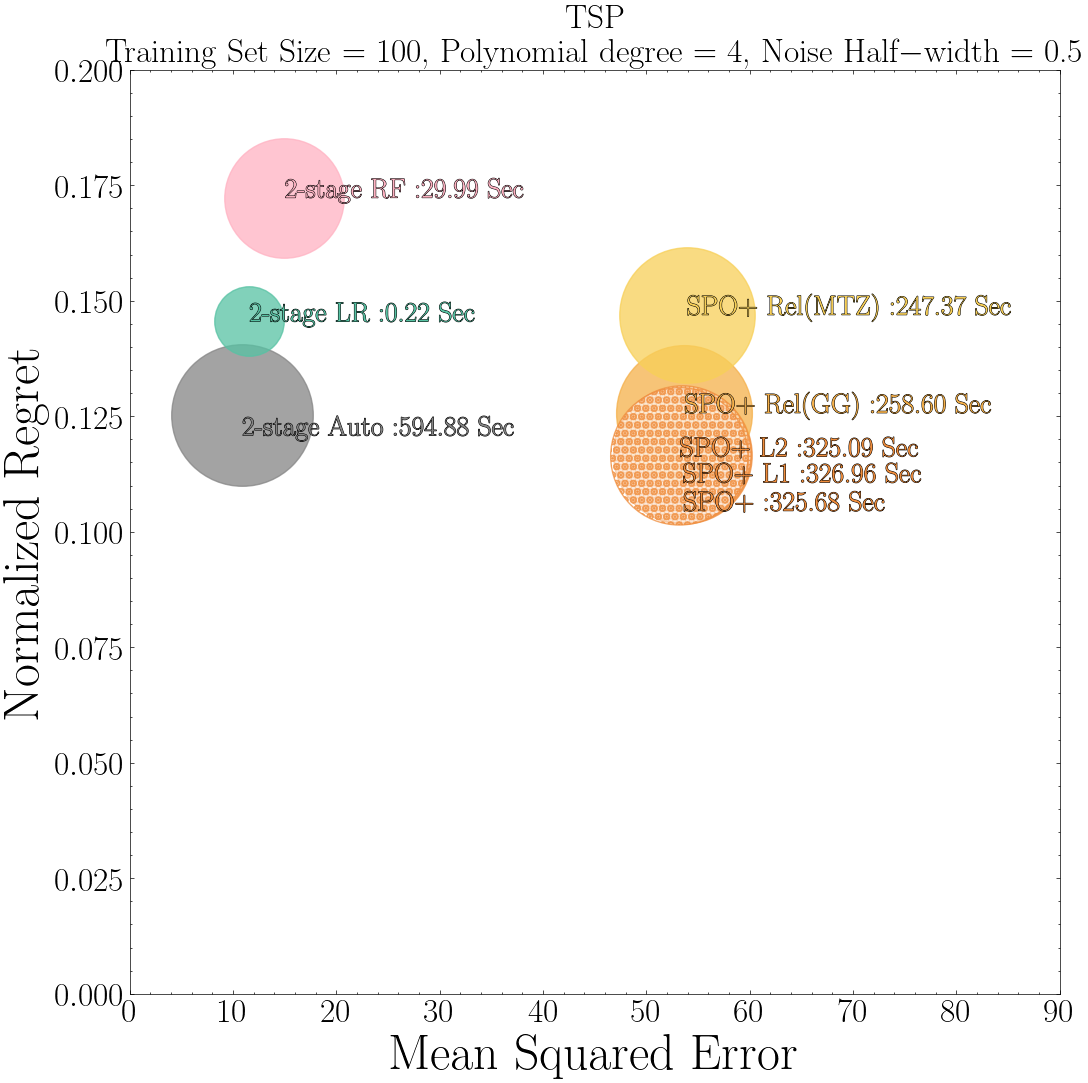

In [18]:
drawPlot(config, data=100)

## n = 1000 

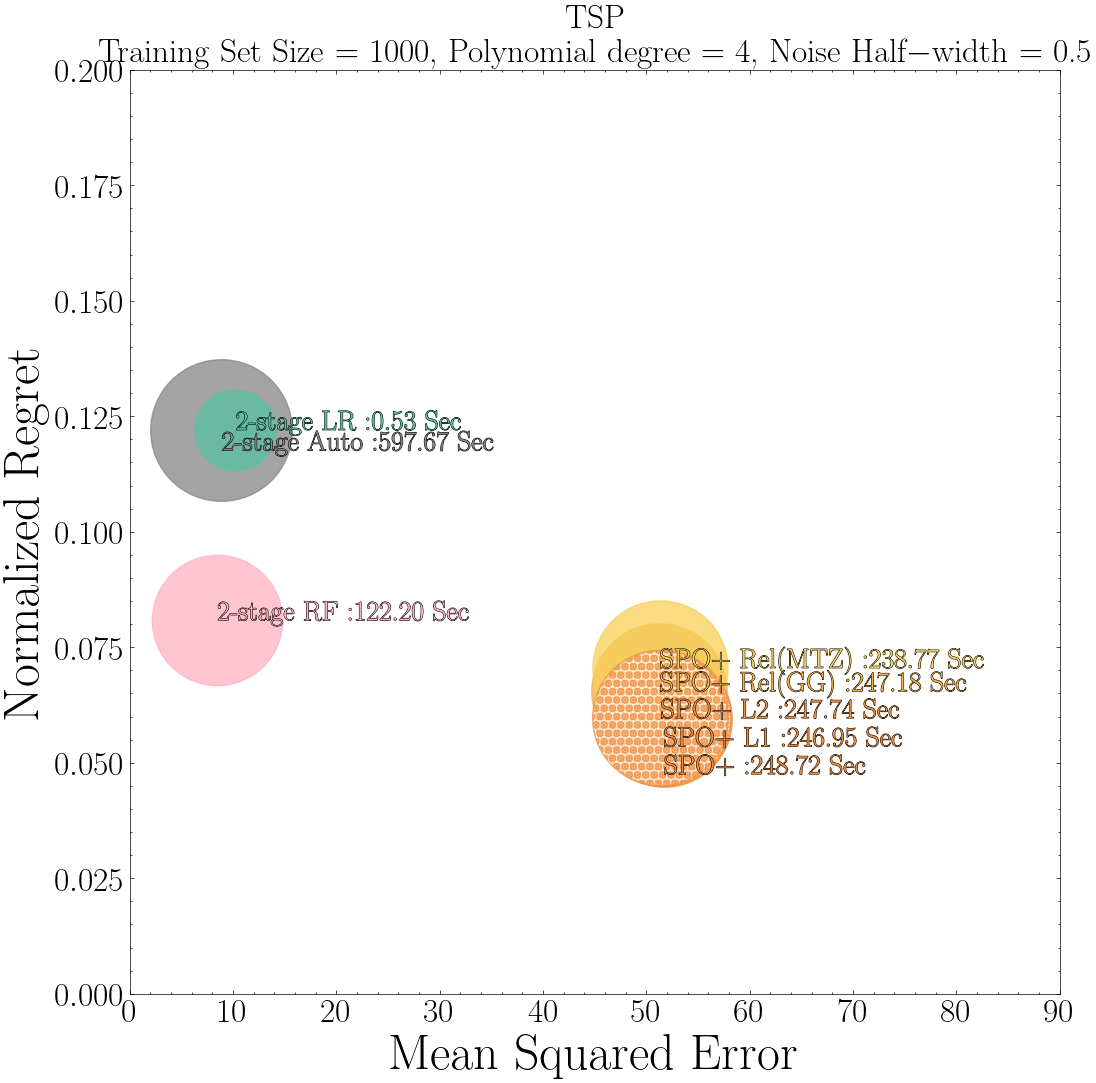

In [19]:
drawPlot(config, data=1000)